In [1]:
cd ..

/home/james/Dropbox (MIT)/All_Resourceful/localgateway/beeview_gateway


In [9]:
from algorithms import np
import pandas as pd
import itertools
import math
import functools
import numpy
import seaborn as sns
import collections
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
})
import matplotlib.pyplot as plt
%matplotlib inline
all_data = pd.read_csv('notebook_analysis/intact_whitenoise_1_100Hz.csv')
coorddata = pd.read_csv('notebook_analysis/node_coords.csv',
                        dtype={'Node':numpy.int64},index_col='Node')

def translater(nodeax):
    node, ax = int(nodeax[0:-1]),nodeax[-1]
    translat = coorddata['Index'].to_dict()
    return translat[node]+ax
nodes = [63,41,15,95,96,53,55,31,22,17,18,56,58,61,64,43,46,49,68,32,37,39,40,69]
allnodes = [i for i in coorddata.index.tolist() if i <100]
print(allnodes)
neighborhoods = {node:[node%4] for node in allnodes}
biggest_modx = lambda lst, x: max([i for i in lst if i%4==x])
largesteach = [(i,biggest_modx(allnodes, i)) for i in range(4)]
for i,largest in largesteach:
    if i+1 in range(4):
        neighborhoods[largest].append(i+1)
print(neighborhoods)

[20, 21, 22, 23, 24, 65, 25, 17, 27, 18, 29, 6, 54, 55, 56, 58, 59, 66, 60, 61, 62, 63, 64, 96, 41, 42, 43, 44, 45, 5, 46, 47, 49, 52, 53, 68, 95, 31, 32, 33, 7, 15, 36, 37, 38, 39, 40, 69]
0 96
1 69
2 66
3 95
{5: [1], 6: [2], 7: [3], 15: [3], 17: [1], 18: [2], 20: [0], 21: [1], 22: [2], 23: [3], 24: [0], 25: [1], 27: [3], 29: [1], 31: [3], 32: [0], 33: [1], 36: [0], 37: [1], 38: [2], 39: [3], 40: [0], 41: [1], 42: [2], 43: [3], 44: [0], 45: [1], 46: [2], 47: [3], 49: [1], 52: [0], 53: [1], 54: [2], 55: [3], 56: [0], 58: [2], 59: [3], 60: [0], 61: [1], 62: [2], 63: [3], 64: [0], 65: [1], 66: [2, 3], 68: [0], 69: [1, 2], 95: [3], 96: [0, 1]}


[(1, 0.0244140625),
 (2, 0.048828125),
 (3, 0.0732421875),
 (616, 15.0390625),
 (615, 15.0146484375),
 (634, 15.478515625),
 (645, 15.7470703125),
 (598, 14.599609375),
 (597, 14.5751953125),
 (640, 15.625)]

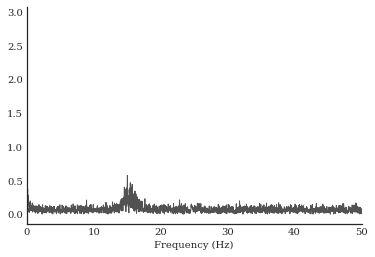

In [10]:
fig, ax= plt.subplots(1)
def get_fs(data, f):
    #eg f= 100 hz, duration =60s
    nbins = int(len(data)/2)
    nyquist = f/2
    stepsize = nyquist/nbins
    fftbins = [i*stepsize for i in range(nbins)]
    return fftbins
def maxer(fs,response):
    biggest = sorted(response,key = lambda x: abs(x), reverse=True)[:10]
    def getvals(x):
        idx = response.index(x)
        return idx, fs[idx]
    return [getvals(i) for i in biggest]
data = all_data['41x'].tolist()[0:2**12]
fft = list(map(abs, np.fft(data)))
fs = get_fs(data, 100)
ax.plot(fs, fft[0:2048], color = '#525252', linewidth=1)
ax.set_xlabel('Frequency (Hz)')
ax.set_xlim([0,50])
sns.despine()
#print('largest response at {}Hz, index{}'.format(*maxer(fs, fft[0:2048])))
maxer(fs, fft[0:2048])

In [43]:
def samplestream(nodes, all_data):
    all_idxs = (str(x)+y for x,y in itertools.product(nodes, ['x','y','z']))
    return [(x, all_data[translater(x)].tolist()[0:2**12]) for x in all_idxs]
def mapper(d):
    idx = 616
    nodeid, data = d
    ftpeak = np.fft(data)[idx]
    c = lambda d: (round(d.real,6),round(d.imag,6))
    return [(0,(nodeid,c(ftpeak)))]
def shuffler(kvstream):
    flat = list(itertools.chain(*kvstream))
    sortedkvs = sorted(flat, key=lambda x: x[0])
    grouped = itertools.groupby(sortedkvs, key=lambda x:x[0])
    return ((k,[i[1] for i in g]) for k,g in grouped)
def reducer(kvs):
    k,vs =kvs
    ws = [complex(*i[1]) for i in vs]
    G = np.spectral_mat(ws)
    eig = np.pagerank(G)
    c = lambda d: (round(d.real,2),round(d.imag,2))
    ms = [(vs[idx][0],c(el)) for idx,el in enumerate(eig)]
    return (k,ms)
def dmapper(neighborhoods, d):
    nodeid, data = d
    nodenum = int(nodeid[0:-1])
    hoods = neighborhoods[nodenum]
    idx = 616
    ftpeak = np.fft(data)[idx]
    c = lambda d: (round(d.real,6),round(d.imag,6))
    return [(i,(nodeid, c(ftpeak))) for i in hoods]

def mr(streamfun, mapfun, redfun):
    mappit = functools.partial(map, mapfun)
    reducit = functools.partial(map,redfun)
    return list(reducit(shuffler(mappit(streamfun()))))
def merger(lst):
    accer = lambda acc, el: acc+el[1]
    return functools.reduce(accer, lst,[])
def dfdd_merger(lst):
    """for example [('0',[('a',(1,2)),('b',(3,4))],
                    ('1',[('b',(2,3)),('c',(4,5))]) -? to equalise bs, must subtract (1,1) from everything in 2
                    ]
    should return [('a',(1,2)),('b',(3,4)),('c',(3+4))
    """
    def accer(acc, el):
        def tuplediff(x,y):
            return (x[0], (x[1][0]-y[1][0],x[1][1]-y[1][1]))
        def tupleadd(x,y):
            return (x[0], (x[1][0]+y[1][0],x[1][1]+y[1][1]))
        def match_or_none(lst, key):
            try:
                matcher = next((i for i in allcombs if key(i)))
                return matcher
            except StopIteration:
                return 
        newnodes = el[1]
        allcombs = list(itertools.product(acc, newnodes))
        matcher = match_or_none(allcombs, key=lambda i: i[0][0]==i[1][0])
        diff = tuplediff(*matcher) if matcher else ('None',(0,0))
        superposed = [tupleadd(i,diff) for i in newnodes]
        acc.update(superposed)
        return acc
    return functools.reduce(accer, lst, set())
import functools
    #return functools.reduce(accer, lst, set())
dfdd_merger([('0',[('a',(1,2)),('b',(3,4))]),
             ['1',[('b',(2,3)),('c',(4,5))]],
             ['2',[('c',(1,3)),('e',(9,1))]]
           ])

{('a', (1, 2)), ('b', (3, 4)), ('c', (5, 6)), ('e', (13, 4))}

In [34]:
stream = functools.partial(samplestream,allnodes, all_data)
r = mr(stream, mapper, reducer)
res = merger(r)

iteration:  0
diff:  9.518398738226493
iteration:  1
diff:  7.665484121822709e-16
converged:  ((-0.014140288700604377-0.0025090975676753274j), (0.019779007838341734-0.015396849803131303j), (0.0073600946275286135-0.003281969894467017j), (-0.03391050860745263-0.010401596780417688j), (0.010340498874531085-0.019000299197642748j), (0.004468540167206995-0.001040894661728711j), (-0.043735837692982234-0.021565145510325307j), (0.07167696008280736-0.05861758900246633j), (-0.0016259100223904846-0.014133961251158633j), (-0.05152936985898457-0.013737991073661643j), (0.07863035540705765-0.039405037984467726j), (0.002805377991153773-0.013441110401303554j), (-0.07562140641594084-0.034943710400138765j), (0.06544709538092394-0.06599177059316814j), (-0.001635877768177739-0.008071984955308831j), (-0.08645401479098967-0.03982008613627546j), (0.07272595766934396-0.05161235405862706j), (0.01642521761349421-0.013355210774060901j), (-0.07785983112995326-0.03445194900174462j), (0.08941617174314281-0.06848224791

In [35]:
streamdfdd = functools.partial(samplestream, allnodes, all_data)
dfddmapper=functools.partial(dmapper,neighborhoods)
rdfdd = mr(streamdfdd, dfddmapper, reducer)
resdfdd = dfdd_merger(rdfdd)

iteration:  0
diff:  5.045012625873055
iteration:  1
diff:  4.4256234924730995e-16
converged:  ((-0.004068910557162354+0.02851392825745108j), (-0.032205665715200844-0.0386002343560594j), (-0.007078464263699415-0.01453002120484154j), (-0.06490649350517386+0.15395281498073382j), (-0.13672257085094486-0.12670307957415336j), (-0.016068777286224484+0.0038273084565760562j), (-0.0029354199351183754+0.09573322186183394j), (-0.07075633169255327-0.08289394013242563j), (0.0064297155098109555+0.04510891054958999j), (-0.04698518766922359+0.15215068888118594j), (-0.15187718390203309-0.15606465564362798j), (0.018945873782370393+0.06638714458771554j), (-0.05646141494897716+0.18778445002296235j), (-0.1458984892365957-0.19213636824722413j), (-0.015466685368898437+0.003402131935703788j), (-0.06907554975883387+0.20665227447920823j), (-0.19280349224019253-0.26304961844377384j), (-0.023348869521572706-0.01339213699435718j), (-0.052296537173147827+0.1409787591629817j), (-0.1455465798865433-0.1915257981855737

In [37]:
def realify(amplitude, phase):
    """take complex mode shape, which means we can express structural
    motion at each point as something like a*sin(wt+phi),
    and return a real value which is a snapshot of this steady state
    motion at t=0"""
    t=0
    w=_
    return abs(complex(amplitude, phase))#amplitude*math.sin(phase)
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z
def mergeaxes(entries):
    """entries is a list of modeshape values for
    a specific node,for example:
    [{'ax': 'x', 'Node': '31', 'val': -0.03}
    , {'ax': 'y', 'Node': '31', 'val': 0.05}]"""
    convert = lambda d: {'Node':d['Node'],2*d['ax']:d['val']}
    return functools.reduce(merge_two_dicts, map(convert, entries),{})
def formatter(res):
    d = [{'Node':k[0:-1],'ax':k[-1], 'val':realify(*v)} for k,v in res]
    grouped = itertools.groupby(d, key = lambda d:d['Node'])
    res = [mergeaxes(group) for k, group in grouped]
    return pd.DataFrame(res)

In [38]:
final = formatter(res)
final.to_csv('notebook_analysis/fddmodeshape.csv', index=False)

In [39]:
dfinal = formatter(resdfdd)
dfinal.to_csv('notebook_analysis/dfddmodeshape.csv', index=False)

In [40]:
rdfdd

[(0,
  [('20x', (0.06, 0.0)),
   ('20y', (-0.08, 0.07)),
   ('20z', (-0.03, 0.02)),
   ('24x', (0.33, 0.12)),
   ('24y', (-0.25, 0.3)),
   ('24z', (0.01, 0.03)),
   ('56x', (0.2, -0.01)),
   ('56y', (-0.16, 0.16)),
   ('56z', (0.09, -0.02)),
   ('60x', (0.32, 0.08)),
   ('60y', (-0.31, 0.34)),
   ('60z', (0.14, -0.05)),
   ('64x', (0.4, 0.09)),
   ('64y', (-0.38, 0.33)),
   ('64z', (0.01, 0.03)),
   ('96x', (0.44, 0.12)),
   ('96y', (-0.52, 0.44)),
   ('96z', (-0.03, 0.05)),
   ('44x', (0.3, 0.09)),
   ('44y', (-0.38, 0.33)),
   ('44z', (0.01, -0.03)),
   ('52x', (0.27, 0.08)),
   ('52y', (-0.18, 0.28)),
   ('52z', (-0.11, 0.03)),
   ('68x', (0.35, 0.08)),
   ('68y', (-0.34, 0.32)),
   ('68z', (-0.05, -0.01)),
   ('32x', (1.0, 0.0)),
   ('32y', (-0.25, 0.26)),
   ('32z', (-0.09, -0.08)),
   ('36x', (0.29, 0.08)),
   ('36y', (-0.08, 0.16)),
   ('36z', (0.01, -0.06)),
   ('40x', (0.35, 0.11)),
   ('40y', (-0.36, 0.3)),
   ('40z', (-0.05, -0.02))]),
 (1,
  [('21x', (0.15, 0.1)),
   ('21y'

In [41]:
resdfdd

{('15x', (0.26, 0.0)),
 ('15y', (-0.03999999999999998, -0.06)),
 ('15z', (0.11000000000000003, -0.18)),
 ('17x', (1.02, 0.0)),
 ('17y', (-0.11, 0.15)),
 ('17z', (0.060000000000000005, 0.03)),
 ('18x', (1.07, -0.04000000000000001)),
 ('18y', (-0.3, 0.27)),
 ('18z', (0.1, -0.05000000000000001)),
 ('20x', (0.06, 0.0)),
 ('20y', (-0.08, 0.07)),
 ('20z', (-0.03, 0.02)),
 ('21x', (0.16999999999999998, 0.1)),
 ('21y', (-0.06, 0.08)),
 ('21z', (3.469446951953614e-18, 0.0)),
 ('22x', (0.29000000000000004, 0.03)),
 ('22y', (-0.22999999999999998, 0.28)),
 ('22z', (0.09000000000000001, 0.01999999999999999)),
 ('23x', (0.38, -0.039999999999999994)),
 ('23y', (-0.19999999999999996, 0.020000000000000018)),
 ('23z', (0.14000000000000004, -0.06)),
 ('24x', (0.33, 0.12)),
 ('24y', (-0.25, 0.3)),
 ('24z', (0.01, 0.03)),
 ('25x', (0.36000000000000004, 0.29)),
 ('25y', (-0.53, 0.21)),
 ('25z', (-0.05, 0.04)),
 ('27x', (1.1600000000000001, -0.12)),
 ('27y', (-0.10999999999999999, 0.06)),
 ('27z', (0.28, -0.